Try to use a novelty detection approach with an autoencoder. See Japkowicz, A Novelty Detection Approach to Classification 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

The basic idea here follows Japkowicz et al, _A Novelty Based Approach to Classification_. This approach is designed for problems where negative examples are plentiful but positive examples are scarse, as in the case for frb detection. It exploits the fact that neural networks generalise poorly to examples outside their training sets. 

First, an autoencoder is trained on the negative examples. This is an unsupervised feature extraction method, which aims to map the input to a lower dimensional _latent space_. This is accomplised by having a network map the input to a hidden layer of lower dimensionality that the input, then attempting to reconstruct the input from this latent space alone, with the loss based on the difference between the ground truth and the models attempt at reconstruction. In order to efficiently do so, the network must capture meaningful features in the latent space. In the blog post I got this implementation of an autoencoder from, the author demonstrates the idea on the well-known MNIST set. 

Our approach to detect novelty is then to use the _error_ in the reconstruction of an example as a measure of the outlier-ness of an observation. Observations similar to those the auto-encoder saw during training will be reconstructed efficiently, wheras unusual observations will have poor reconstruction. We can this to a 'probablity' using a softmax

Here, we are using a 'Variational autoencoder' which does some fancier stuff. Possibly we need to play round with the complexity of the model.

The really nice thing about this is that we can carry out cross validation _only on the noise data_, to get the reconstruction error as low as possible, and use our simulations sparingly. 


In [2]:
"credit: https://jmetzen.github.io/2015-11-27/vae.html"

def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.relu, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, 
                        tf.mul(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog, 
                            n_hidden_gener,
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h': tf.Variable(xavier_init(n_input, n_hidden_recog)),
            #'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog, n_z))}
        all_weights['biases_recog'] = {
            'b': tf.Variable(tf.zeros([n_hidden_recog], dtype=tf.float32)),
            #'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h': tf.Variable(xavier_init(n_z, n_hidden_gener)),
            #'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener, n_input))}
        all_weights['biases_gener'] = {
            'b': tf.Variable(tf.zeros([n_hidden_gener], dtype=tf.float32)),
            #'b2': tf.Variable(tf.zeros([n_hidden_gener], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        hidden_layer = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h']), 
                                           biases['b'])) 
        #layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                      #     biases['b2'])) 
        z_mean = tf.add(tf.matmul(hidden_layer, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(hidden_layer, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        hidden_layer = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h']), 
                                           biases['b'])) 
        #layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
        #                                   biases['b2'])) 
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(hidden_layer, weights['out_mean']), 
                                 biases['out_mean']))
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-5 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-5 + 1 - self.x_reconstr_mean),
                           1)
        
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})
    
def train(network_architecture, data_batches, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    data_batches.batch_size = batch_size
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs = data_batches.get_batch()
            
            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        #if epoch % display_step == 0:
         #   print("Epoch:", '%04d' % (epoch+1), 
        #        "cost=", "{:.9f}".format(avg_cost))
    return vae

In [3]:
"""Load some frb data"""

with open("frb_datasets/w_snr_dm_nn_score.dat") as f:
    data_file = [[float(field) for field in line.strip().split(' ')] for line in f]
    
all_data = np.array(data_file, dtype=np.float32)

#remove all frbs from the dataset: we only want to train the encoder on noise, in order to detect outliers 

non_frbs = all_data[all_data[:,-1] == 0][:,:-1]
frbs = all_data[all_data[:,-1] == 1][:,:-1]
    
    

In [4]:
class batch_creator(object):
    def __init__(self, data, batchsize = 100):
        self.data = data
        self.batchsize = batchsize
        self.counter = 0 
        self.datasize = self.data.shape[0]
        self.generator = self.batch_iter()
    def batch_iter(self):
        while(True):
            end_batch = self.counter + self.batchsize 
            yield self.data[self.counter:end_batch]
            if end_batch > self.datasize:
                self.counter = 0
                np.random.shuffle(self.data)
    def get_batch(self):
        return self.generator.next()

In [46]:
network_architecture = dict(n_hidden_recog = 100,
                        n_hidden_gener = 100,
                        n_input = 4,
                        n_z = 2)
n_samples = non_frbs.shape[0]

#normalise frbs so each has mean one 
normalised_frbs = np.copy(frbs)
normalised_non_frbs = np.copy(non_frbs)

for i in xrange(normalised_non_frbs.shape[1]):
    norm_factor = np.max(normalised_non_frbs[:,i])
    normalised_non_frbs[:,i] /= norm_factor
    normalised_frbs[:,i] /= norm_factor


In [56]:
#test under cross validation to control overfitting, computing the ROC curves as we go 
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_curve, roc_auc_score 

batch_size = 100
training_epochs = 300
cv = KFold(n_splits = 5)
roc_curves = []
roc_curve_scores = []

np.random.shuffle(normalised_non_frbs)

for train_inds, test_inds in cv.split(normalised_non_frbs, normalised_non_frbs):
    #we don't have y's, so just pass normalised_non_frbs in twice to make the function happy. 
    train_x = normalised_non_frbs[train_inds]
    
    #testing set consists of noise with FRBS added to it 
    test_x = np.concatenate([normalised_non_frbs[test_inds], normalised_frbs])
    
    test_labels = np.array([0 for _ in test_inds] + [1 for _ in normalised_frbs])
    
    vae = train(network_architecture,
                batch_creator(train_x),
                training_epochs = training_epochs,
                batch_size=batch_size)
    #need to pass in whole number of the batch size 
    buffer_mul = int(np.ceil(float(test_x.shape[0]) / batch_size))
    buf = np.zeros([batch_size * buffer_mul, normalised_non_frbs.shape[1]])
    buf_recon = np.zeros([batch_size * buffer_mul, normalised_non_frbs.shape[1]])
    for i in xrange(test_x.shape[0]):
        buf[i,:] = test_x[i,:]
    for i in xrange(buffer_mul):
        ind = batch_size * i
        buf_recon[ind:ind + batch_size] = vae.reconstruct(buf[ind:ind + batch_size])
        
    
    test_recon = buf_recon[:test_x.shape[0]]
    scores = ((test_recon - test_x) **2).sum(axis = 1) #mean squared reconstruction error 
    
    #get the ROC curve and AUC 
    roc_curves.append(roc_curve(test_labels, scores, pos_label = 1))
    roc_curve_scores.append(roc_auc_score(test_labels, scores))
    


Plot the ROC and mean ROC curves for these features: 

Mean AUC score: 0.811767031694


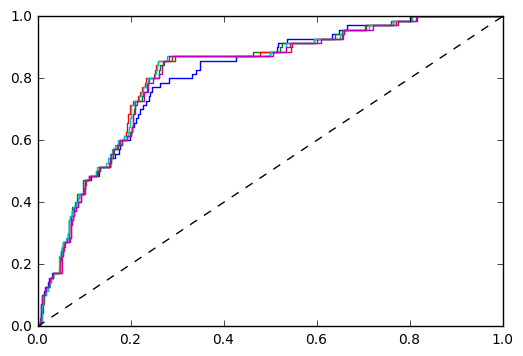

In [57]:
%matplotlib inline

for fpr, tpr, _ in roc_curves: 
    plt.plot(fpr, tpr, linestyle = '-')

    
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), color='k', linestyle='--')
print "Mean AUC score: {}".format(sum(roc_curve_scores) / 5)

AUC Score for feature: 0.931565856891


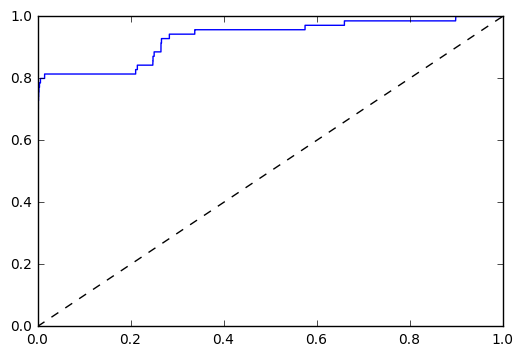

In [54]:
#compare this to using the SNR as a cutoff threshold 
feat = 1
data_all = np.concatenate([non_frbs, frbs])
data_labs = np.array([0 for _ in non_frbs] + [1 for _ in frbs])
fpr, tpr, _ = roc_curve(data_labs, data_all[:,feat], pos_label = 1)
plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), color='k', linestyle='--')

print "AUC Score for feature: {}".format(roc_auc_score(data_labs, data_all[:,feat]))

Since the SNR is a very good score by itself, try removing it from the training set and see if the novelty detector is still a useful filter 

In [63]:
network_architecture = dict(n_hidden_recog = 50,
                        n_hidden_gener = 50,
                        n_input = 3,
                        n_z = 2)
n_samples = non_frbs.shape[0]

roc_curves_no_snr = []
roc_curve_scores_no_snr = []

#normalise frbs so each has mean one 
normalised_frbs_no_snr = normalised_frbs[:,[0,2,3]]
normalised_non_frbs_no_snr = normalised_non_frbs[:,[0,2,3]]

for train_inds, test_inds in cv.split(normalised_non_frbs_no_snr, normalised_non_frbs_no_snr):
    #we don't have y's, so just pass normalised_non_frbs_no_snr in twice to make the function happy. 
    train_x = normalised_non_frbs_no_snr[train_inds]
    
    #testing set consists of noise with FRBS added to it 
    test_x = np.concatenate([normalised_non_frbs_no_snr[test_inds], normalised_frbs_no_snr])
    
    test_labels = np.array([0 for _ in test_inds] + [1 for _ in normalised_frbs_no_snr])
    
    vae = train(network_architecture,
                batch_creator(train_x),
                training_epochs = training_epochs,
                batch_size=batch_size)
    #need to pass in whole number of the batch size 
    buffer_mul = int(np.ceil(float(test_x.shape[0]) / batch_size))
    buf = np.zeros([batch_size * buffer_mul, normalised_non_frbs_no_snr.shape[1]])
    buf_recon = np.zeros([batch_size * buffer_mul, normalised_non_frbs_no_snr.shape[1]])
    for i in xrange(test_x.shape[0]):
        buf[i,:] = test_x[i,:]
    for i in xrange(buffer_mul):
        ind = batch_size * i
        buf_recon[ind:ind + batch_size] = vae.reconstruct(buf[ind:ind + batch_size])
        
    
    test_recon = buf_recon[:test_x.shape[0]]
    scores = ((test_recon - test_x) **2).sum(axis = 1) #mean squared reconstruction error 
    
    #get the ROC curve and AUC 
    roc_curves_no_snr.append(roc_curve(test_labels, scores, pos_label = 1))
    roc_curve_scores_no_snr.append(roc_auc_score(test_labels, scores))
    



Mean AUC score: 0.355485800724


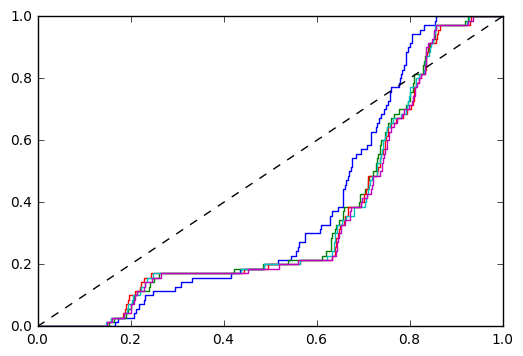

In [65]:
for fpr, tpr, _ in roc_curves_no_snr: 
    plt.plot(fpr, tpr, linestyle = '-')

    
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), color='k', linestyle='--')
print "Mean AUC score: {}".format(sum(roc_curve_scores_no_snr) / 5)

In [74]:
#try an isolation forest 
from sklearn.ensemble import IsolationForest

cv = KFold(n_splits = 5)
roc_curves_ifrst = []
roc_curve_scores_ifrst = []

np.random.shuffle(normalised_non_frbs)

for train_inds, test_inds in cv.split(normalised_non_frbs, normalised_non_frbs):
    #we don't have y's, so just pass normalised_non_frbs in twice to make the function happy. 
    train_x = normalised_non_frbs[train_inds]
    
    #testing set consists of noise with FRBS added to it 
    test_x = np.concatenate([normalised_non_frbs[test_inds], normalised_frbs])
    
    test_labels = np.array([0 for _ in test_inds] + [1 for _ in normalised_frbs])
    
    ifrst = IsolationForest()
    ifrst.fit(train_x)
    scores = -1 * ifrst.decision_function(test_x)
    roc_curves_ifrst.append(roc_curve(test_labels, scores))
    roc_curve_scores_ifrst.append(roc_auc_score(test_labels, scores))
    


Mean AUC score: 0.96571582726


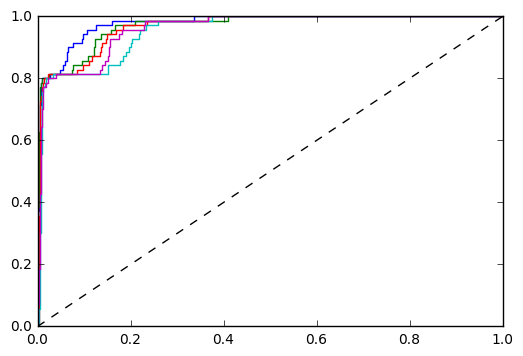

In [75]:
for fpr, tpr, _ in roc_curves_ifrst: 
    plt.plot(fpr, tpr, linestyle = '-')

    
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), color='k', linestyle='--')
print "Mean AUC score: {}".format(sum(roc_curve_scores_ifrst) / 5)

array([ 1,  1,  1, ..., -1, -1, -1])

array([ 0.09283166,  0.09475361,  0.12375692, ..., -0.11870164,
       -0.13771524, -0.14571977])